<a href="https://colab.research.google.com/github/minjoo1412/2020_AI/blob/master/%EA%B3%BC%EC%A0%9C4%EC%A0%95%EB%8B%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3번

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['names/English.txt', 'names/Irish.txt', 'names/Scottish.txt', 'names/French.txt', 'names/Japanese.txt', 'names/Vietnamese.txt', 'names/Dutch.txt', 'names/Chinese.txt', 'names/Czech.txt', 'names/Spanish.txt', 'names/German.txt', 'names/Polish.txt', 'names/Italian.txt', 'names/Russian.txt', 'names/Portuguese.txt', 'names/Korean.txt', 'names/Greek.txt', 'names/Arabic.txt']
Slusarski


In [ ]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8462, -2.8547, -2.9517, -2.7451, -2.8619, -2.8903, -2.8562, -2.9349,
         -2.9847, -2.9299, -2.9012, -2.9031, -2.9425, -2.8920, -2.8757, -2.9362,
         -2.8001, -2.9507]], grad_fn=<LogSoftmaxBackward>)


In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 3)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Agelakos
category = Arabic / line = Baba
category = German / line = Aleshite
category = Greek / line = Christodoulou
category = Chinese / line = Moy
category = Russian / line = Piskorsky
category = Russian / line = Ajnikov
category = Italian / line = Abramo
category = Vietnamese / line = Truong
category = Chinese / line = Min


In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


5000 5% (0m 7s) 1.5604 Phocas / Greek ✓
10000 10% (0m 15s) 1.0808 Achteren / Dutch ✓
15000 15% (0m 22s) 3.7353 Kann / Korean ✗ (Dutch)
20000 20% (0m 30s) 2.2151 Vodden / Dutch ✗ (English)
25000 25% (0m 37s) 1.2590 Aritza / Spanish ✓
30000 30% (0m 45s) 2.6704 Inouye / French ✗ (Japanese)
35000 35% (0m 53s) 0.0805 Arvanitoyannis / Greek ✓
40000 40% (1m 0s) 1.3093 Demetrious / Greek ✓
45000 45% (1m 8s) 1.5161 Senft / German ✓
50000 50% (1m 16s) 0.0024 Baitchikov / Russian ✓
55000 55% (1m 24s) 0.0858 Wojewodka / Polish ✓
60000 60% (1m 31s) 2.0472 Dubicki / Italian ✗ (Polish)
65000 65% (1m 39s) 0.8554 Ahn / Korean ✓
70000 70% (1m 46s) 0.2407 Safar / Arabic ✓
75000 75% (1m 54s) 3.3739 Toset / Dutch ✗ (Spanish)
80000 80% (2m 1s) 3.8140 Gerges / German ✗ (Arabic)
85000 85% (2m 9s) 0.2250 Ta / Vietnamese ✓
90000 90% (2m 17s) 1.0029 Sakellariou / Greek ✓
95000 95% (2m 24s) 0.1151 Toyama / Japanese ✓
100000 100% (2m 32s) 2.7189 Holub / Arabic ✗ (Czech)


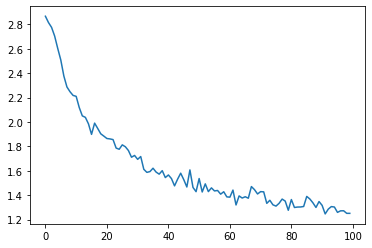

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

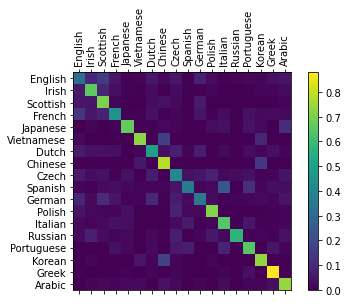

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.91) Czech
(-1.04) Russian
(-2.01) English

> Jackson
(-0.08) Scottish
(-2.84) English
(-5.45) Russian

> Satoshi
(-1.04) Japanese
(-1.41) Arabic
(-1.69) Italian


- char 단위로 이름의 국적을 추적하는 것입니다.(목적)
- 각 데이터 파일에는 각 언어별로 이름들이 포함되어 있으며 이를 `language: [names ...]}`의 형태로 만들어서 데이터를 준비합니다.(데이터 준비과정)
- 신경망의 입력 값은 input과 초기 hidden을 합친 `combined`를 사용해서 두개의 선형 레이어를 통과합니다. 출력값은 `i2o`를 통과한 `output`과 `i2h`를 통과한 `hidden`을 합쳐서 생성됩니다.(네트워크 설명)
- `categoryFromOutput`는 결과값에서 가장 큰 값의 인덱스를 사용해서 카테고리를 예측합니다. 
- 마지막 출력 값에 `nn.LogSoftmax`를 쓰기 때문에 오차 함수로는 `nn.NLLLoss()`를 사용합니다. 
- 훈련을 반복하면서 입력 값과 타겟 값을 텐서로 만들고, 0으로 초기화된 hidden state를 생성합니다. 이후 각 글자를 읽어오고 다음 글자를 위해서 hidden state은 유지합니다. 마지막 결과 값과 타겟 값을 비교한 후, 역전파를 진행합니다. (훈련 과정 설명)
- 오차에 대한 그래프를 그리면 오차가 점차 감소하고 있는 것을 확인할 수 있습니다. 또한 confusion matrix를 그리면 각각의 카테고리에 대한 네트워크의 성능을 보여줍니다. 마지막으로 새로운 이름을 사용해서 예측한 결과를 볼 수 있습니다. (결과 해석)

# 4번

In [ ]:
!pip install torch<=1.2.0
!pip install torchtext==0.04 
%matplotlib inline

/bin/bash: =1.2.0: No such file or directory
     |████████████████████████████████| 61kB 3.3MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
import torch
import torchtext
from torchtext.datasets import text_classification
NGRAMS = 2
import os
if not os.path.isdir('./.data'):
	os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ag_news_csv.tar.gz: 11.8MB [00:00, 43.9MB/s]
120000lines [00:09, 13204.54lines/s]
120000lines [00:19, 6130.23lines/s]
7600lines [00:01, 6740.34lines/s]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [ ]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)
    
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [ ]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()
    
    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [ ]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 27 seconds
	Loss: 0.0263(train)	|	Acc: 84.6%(train)
	Loss: 0.0001(valid)	|	Acc: 88.0%(valid)
Epoch: 2  | time in 0 minutes, 27 seconds
	Loss: 0.0120(train)	|	Acc: 93.6%(train)
	Loss: 0.0000(valid)	|	Acc: 90.0%(valid)
Epoch: 3  | time in 0 minutes, 27 seconds
	Loss: 0.0070(train)	|	Acc: 96.3%(train)
	Loss: 0.0000(valid)	|	Acc: 91.3%(valid)
Epoch: 4  | time in 0 minutes, 27 seconds
	Loss: 0.0039(train)	|	Acc: 98.1%(train)
	Loss: 0.0000(valid)	|	Acc: 91.1%(valid)
Epoch: 5  | time in 0 minutes, 27 seconds
	Loss: 0.0023(train)	|	Acc: 99.0%(train)
	Loss: 0.0000(valid)	|	Acc: 91.1%(valid)


In [ ]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0003(test)	|	Acc: 88.4%(test)


In [ ]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

vocab = train_dataset.get_vocab()
model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, model, vocab, 2)])

This is a Sports news


- 텍스트 분류 데이터 셋을 사용해서 텍스트의 내용을 카테고리 별로 분류하고자 합니다.(목적)
- `ngrams`을 2로 설정해서 bi-grams문자열이 더해진 리스트를 생성합니다. (데이터 준비과정)
- 모델은 `EmbeddingBag`레이어와 선형 레이어로 구성되어 있습니다. 

# 5번

In [ ]:
%matplotlib inline

In [ ]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 951kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=4340166976090c2674cec05850ae5d3cc257a0f861c0515cc3315c6ebb2b90ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-sxu41m4q/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:04<00:00, 283kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 91.3kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 86.8kB/s]


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

In [ ]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor


class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden


class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tuple[Tensor]:

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0)


class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        # 디코더로의 첫 번째 입력은 <sos> 토큰입니다.
        output = trg[0,:]

        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
# ENC_EMB_DIM = 256
# DEC_EMB_DIM = 256
# ENC_HID_DIM = 512
# DEC_HID_DIM = 512
# ATTN_DIM = 64
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)


def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

optimizer = optim.Adam(model.parameters())


def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,856,685 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
import math
import time


def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0

    for _, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 7m 50s
	Train Loss: 5.675 | Train PPL: 291.432
	 Val. Loss: 5.244 |  Val. PPL: 189.365
Epoch: 01 | Time: 7m 50s
	Train Loss: 5.675 | Train PPL: 291.432
	 Val. Loss: 5.244 |  Val. PPL: 189.365
Epoch: 02 | Time: 7m 47s
	Train Loss: 5.032 | Train PPL: 153.280
	 Val. Loss: 5.133 |  Val. PPL: 169.518
Epoch: 02 | Time: 7m 47s
	Train Loss: 5.032 | Train PPL: 153.280
	 Val. Loss: 5.133 |  Val. PPL: 169.518
Epoch: 03 | Time: 7m 36s
	Train Loss: 4.776 | Train PPL: 118.641
	 Val. Loss: 4.982 |  Val. PPL: 145.788
Epoch: 03 | Time: 7m 36s
	Train Loss: 4.776 | Train PPL: 118.641
	 Val. Loss: 4.982 |  Val. PPL: 145.788
Epoch: 04 | Time: 7m 44s
	Train Loss: 4.616 | Train PPL: 101.041
	 Val. Loss: 5.113 |  Val. PPL: 166.162
Epoch: 04 | Time: 7m 44s
	Train Loss: 4.616 | Train PPL: 101.041
	 Val. Loss: 5.113 |  Val. PPL: 166.162
Epoch: 05 | Time: 7m 44s
	Train Loss: 4.485 | Train PPL:  88.695
	 Val. Loss: 5.070 |  Val. PPL: 159.114
Epoch: 05 | Time: 7m 44s
	Train Loss: 4.485 | Train PPL

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.955 | Test PPL: 141.939 |
